# DELETWEET DELETION TIMES

In [1]:
import json
import nltk
import pandas
import matplotlib
from datetime import datetime
from matplotlib import pyplot as plt
from nltk.tokenize import TweetTokenizer

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [18.0, 12.0]

## *PARSE DATA*

The Politwoops dataset came with two fields, 'created' and 'modified', that contain information about how long the tweet was live before it was deleted. The 'created' field corresponds to the time the tweet was originally created, whereas the 'modified' field corresponds to the last modification made to the tweet, which in the case would be when it was deleted. To determine the time the tweet was live it is a simple difference between the two fields.

To achieve this we import the data and remove bad rows not originally caught by pandas.read_csv. We then convert the two relevant fields into datetime objects, which will allow for easy subtraction in python, and add a new column to our dataframe that represents the difference between the two.

In [2]:
# import dataset
deletweet = pandas.read_csv('../../deletweet/data/deleted_tweets_cleaned.csv')

In [57]:
# convert time fields in dataframe to datetime objects for easier analysis
deletweet['created'] = pandas.to_datetime(deletweet['created'])
deletweet['modified'] = pandas.to_datetime(deletweet['modified'])

In [58]:
# add new column to dataframe for the time difference from tweet creation to deletion
deletweet['time_diff'] = deletweet['modified'] - deletweet['created']

## *PLOT AND ANALYSIS*

Two different papers on tweet analysis ([here](http://www.cs.cmu.edu/~bliu1/Hazim_Almuhimedi_CSCW2013_Tweets.pdf) and [here](http://www2016.net/proceedings/proceedings/p603.pdf)) task themselves with determining for what reason a tweet has been deleted, based on the tweet's content and metadata alone. Both of them find that tweets that are deleted soon after their creation - as in a matter of seconds to several hours - are overwhelmingly deleted for aesthetic reasons, such as misspellings, improper formatting, and broken or misdirected links. They go on to say that tweets that are live a little longer before being deleted are more likely to be classified as 'regrettable', and that anywhere from two hours to ten hours can be the threshold or decision boundary between the two reasons.

The reasons for regret are varied, and the papers are both a little murky in defining what they could be. However this set of tweets is political by nature, and given that the tweets are likely to be in service of forming and supporting a positive public image for the politicians, regret could be more clearly expressed as doing harm to this image or public opinion. However this is more conjecture than fact, and is simply something interesting to keep in mind.

A look at the basic statistics of the 'time_diff' field show that the time for deletion varies greatly, from essentially instantly to over 5 years later. However the 50th percentile is only about 8 minutes, which means that over half the tweets have most likely been deleted for aesthetic reasons.

In [5]:
deletweet['time_diff'].describe()

count                       67756
mean      97 days 08:50:35.898990
std      246 days 15:10:23.122675
min               0 days 00:00:00
25%        0 days 00:00:33.750000
50%               0 days 00:07:54
75%       19 days 21:19:45.750000
max            1888 days 02:34:13
Name: time_diff, dtype: object

In [6]:
# make pandas series of time_diff column expressed as seconds for plotting
seconds = pandas.Series([deletweet['time_diff'][i].seconds for i in range(len(deletweet))], index=[deletweet['id'][i] for i in range(len(deletweet))])
seconds_sorted = sorted(seconds)

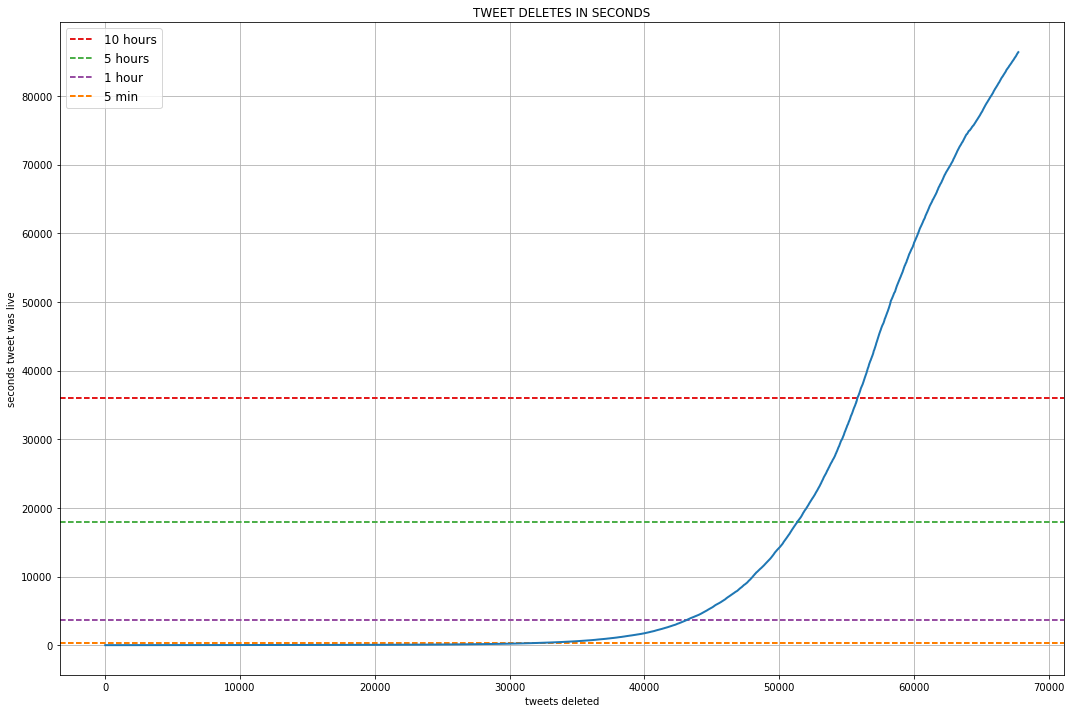

In [7]:
plt.figure()
plt.title('TWEET DELETES IN SECONDS')
plt.xlabel('tweets deleted')
plt.ylabel('seconds tweet was live')
plt.grid(True)
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000])
plt.axhline(y=36000, linewidth=2, color = '#e41a1c', linestyle='dashed', label='10 hours')
plt.axhline(y=18000, linewidth=2, color = '#4daf4a', linestyle='dashed', label='5 hours')
plt.axhline(y=3600, linewidth=2, color = '#984ea3', linestyle='dashed', label='1 hour')
plt.axhline(y=300, linewidth=2, color = '#ff7f00', linestyle='dashed', label='5 min')
plt.legend(prop={'size':12})
plt.plot(seconds_sorted, linewidth=2)

In [8]:
# make buckets to sort by time tweet was live before being deleted
times = {'0-5 min': 300, '1-2 hrs': 7200, '15-30 min': 1800, '2-5 hrs': 18000, '30 min - 1 hr': 3600, '5-10 hrs': 36000, '5-15 min': 900, '>10hrs': 36000}
times_list = ['0-5 min', '5-15 min', '15-30 min', '30 min - 1 hr', '1-2 hrs', '2-5 hrs', '5-10 hrs', '>10hrs']

grouped = {key: [] for key in times.keys()}

for tweet in seconds.iteritems():
    if tweet[1] <= times['0-5 min']:
        grouped['0-5 min'].append(tweet[0])
    elif tweet[1] <= times['5-15 min'] and tweet[1] > times['0-5 min']:
        grouped['5-15 min'].append(tweet[0])
    elif tweet[1] <= times['15-30 min'] and tweet[1] > times['5-15 min']:
        grouped['15-30 min'].append(tweet[0])
    elif tweet[1] <= times['30 min - 1 hr'] and tweet[1] > times['15-30 min']:
        grouped['30 min - 1 hr'].append(tweet[0])
    elif tweet[1] <= times['1-2 hrs'] and tweet[1] > times['30 min - 1 hr']:
        grouped['1-2 hrs'].append(tweet[0])
    elif tweet[1] <= times['2-5 hrs'] and tweet[1] > times['1-2 hrs']:
        grouped['2-5 hrs'].append(tweet[0])
    elif tweet[1] <= times['5-10 hrs'] and tweet[1] > times['2-5 hrs']:
        grouped['5-10 hrs'].append(tweet[0])
    elif tweet[1] > times['5-10 hrs']:
        grouped['>10hrs'].append(tweet[0])

In [124]:
# print number of tweets in each timeframe
for time in times_list:
    print('{:,}: {}'.format(len(grouped[time]), time))

31,723: 0-5 min
5,282: 5-15 min
3,160: 15-30 min
2,917: 30 min - 1 hr
3,280: 1-2 hrs
5,012: 2-5 hrs
4,441: 5-10 hrs
11,941: >10hrs


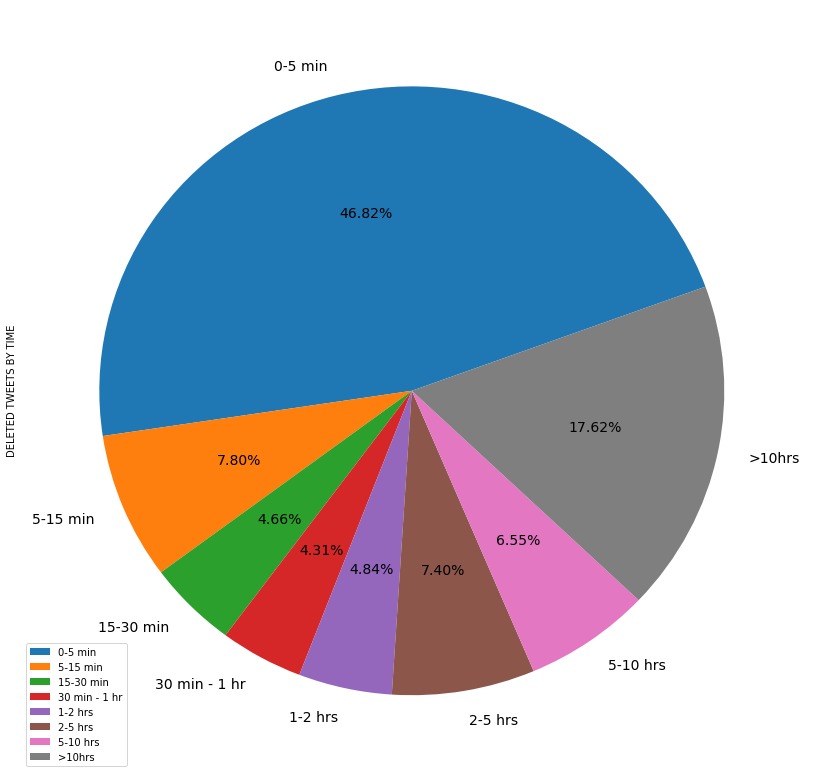

In [51]:
# transform into pandas series for plotting
tweet_series = pandas.Series([len(grouped[times_list[i]]) for i in range(len(grouped))], index=times_list, name='DELETED TWEETS BY TIME')
tweet_series.plot.pie(figsize=(14, 14), fontsize=14, autopct='%.2f%%', startangle=20, legend=True)

The graphs above indicate that close to half the tweets are deleted within 5 minutes of posting, and that almost 70% are deleted within 1 hour of posting. This is a good indication that the majority of this dataset is likely to have been deleted for aesthetic reasons.

Further analysis is needed into the content of the other 25% of the tweets to see if they can be classified as 'regrettable' or not. One potential method of approach for this would be to use a list of words associated with regret; another would be to analyze the content of the those tweets to see if they deal with any hotly contested or politically sensitive issues.

## *CONTENT ANALYSIS OF TWEETS DELETED AFTER 10 HOURS*

In [125]:
# ids of the tweets that were deleted after 10 or more hours
subset_ids = grouped['>10hrs']

In [12]:
# construct a list of strings to hold the tweet text
tweet_text_raw = []

for thing in deletweet['id'].iteritems():
    if thing[1] in subset_ids:
        tweet_text_raw.append(deletweet['content'][thing[0]])

In [126]:
# number of tweets in the 10+ hour subset
len(tweet_text_raw)

11941

In [14]:
# subset's % of total
print('{:.2%}'.format(len(tweet_text_raw) / len(deletweet)))

17.62%


In [127]:
# find number of retweets in the subset
retweet_count = 0

for thing in deletweet['id'].iteritems():
    if thing[1] in subset_ids:
        tweet = json.loads(deletweet['tweet'][thing[0]])
        if 'retweeted_status' in tweet.keys():
            retweet_count += 1

print(retweet_count)

4826


In [129]:
# retweets as percentage of total tweets in 10+ hour subset
print('{:.2%}'.format(retweet_count / len(subset_ids)))

40.42%


In [17]:
# tokenize with NLTK's tweet tokenizer and convert to NLTK text object
tweet_string = ' '.join(tweet_text_raw)

tknzr = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
tweet_tokenized = tknzr.tokenize(tweet_string)

text = nltk.Text(tweet_tokenized)

In [18]:
# remove stopwords, punctuation
stopwords = nltk.corpus.stopwords.words('english')
punctuation_etc = ['.', ':', ',', '!', '"', '-', '…', '...', "’", '?', '/', "'", '(', ')', '“', '”', '&', '%']
filtered = [w for w in tweet_tokenized if w.lower() not in stopwords]
filtered = [w for w in filtered if w.lower() not in punctuation_etc]

processed = []

# remove numbers
for i in range(len(filtered)):
    try:
        float(filtered[i])
    except ValueError:
        processed.append(filtered[i])


text_normalized = nltk.Text(processed)

In [19]:
# percentage of text remaining after normalizing
print('{:.2%}'.format(len(text_normalized) / len(text)))

55.89%


In [20]:
words_normalized = [w.lower() for w in text_normalized]
vocab_normalized = sorted(set(words_normalized))

# of unique words in normalized text
len(vocab_normalized)

25146

In [21]:
# lexical diversity
print('{:.2%}'.format(len(vocab_normalized) / len(words_normalized)))

20.99%


In [130]:
# top 50 bigrams that frequently occur together
text_normalized.collocations(50)

added video; video playlist; #tg4lg #jobsnow; #mtsen #mtpol; looking
forward; #azgov #ducey2014; health care; hansen clarke; common sense;
renee ellmers; middle class; make sure; early voting; john mica;
colbert busch; president obama; last night; doug collins; town hall;
photo facebook; good luck; student loan; high school; little rock;
spread word; #flipadistrict #fl07; posted new; #ar2 #argop; #txsen
#ibleedtx; mike waite; minimum wage; tea party; http://t . ...; small
business; phone bank; don't forget; thoughts prayers; chamber
commerce; wall street; election day; new photo; south carolina; great
time; #betterknowachallenger #fl7; #colbertbump
#betterknowachallenger; midnight momentum; hard work; it's time; fox
news; monday midnight


In [131]:
# 50 most common words
fdist = nltk.FreqDist(text_normalized)
common = fdist.most_common(50)
pandas.Series([common[i][1] for i in range(len(common))], index=[common[i][0] for i in range(len(common))])

rt             5265
today           906
great           645
support         499
vote            498
thank           437
thanks          436
us              431
$               419
time            403
w               392
day             391
new             376
get             372
rep             369
help            360
house           337
congress        315
#tg4lg          313
http            311
tonight         304
need            278
#nc02           271
join            270
bill            268
people          262
video           262
obama           260
#ia03           250
county          241
i'm             240
please          234
work            230
make            219
campaign        218
proud           217
see             213
good            213
president       204
tomorrow        200
congressman     199
it's            198
one             191
jobs            187
#obamacare      185
first           185
via             183
watch           182
state           181
like            179


In [24]:
# words longer than 4 characters occurring more than 100 times
for frequent in sorted(word for word in set(text) if len(word) > 4 and fdist[word] > 100):
    print(frequent)

#ia03
#jobsnow
#nc02
#obamacare
#tg4lg
#txsen
added
america
american
better
budget
campaign
check
collins
congress
congressional
congressman
country
county
district
don't
election
ellmers
families
family
first
follow
friends
great
happy
health
honored
house
let's
meeting
morning
national
obama
office
people
playlist
please
president
proud
rehberg
right
senate
service
stand
state
support
talking
thank
thanks
today
tomorrow
tonight
veterans
video
voted
voting
washington
watch
women
working
would
years


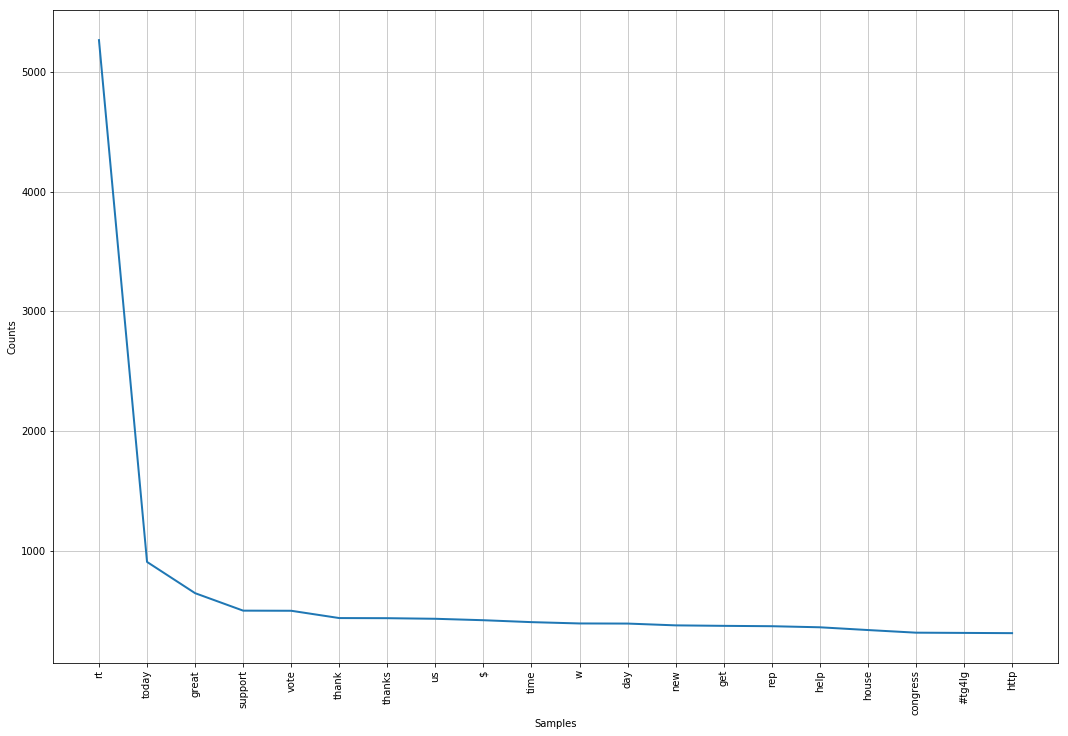

In [132]:
# plot frequencies of top 20 words
fdist.plot(20)

In [27]:
fdist.freq('obama')

0.0021698853299060273

In [28]:
fdist.freq('rt')

0.043940177930597055

In [29]:
text.similar('obama')

the rt and congress us you to all it me what tomorrow live support now
watch on washington seniors vote


In [30]:
text_normalized.similar('obama')

get rt rep today excited freshman helped coordinated using nothing w
tx representatives science joined http startups az pataki canvassing


In [31]:
text_normalized.similar('$')

No matches


## *MOST COMMON DELETION TIMES*

In [113]:
# sort tweets by hour and they were created
created_hours = {i: [] for i in range(24)}
created_days = {i: [] for i in range(7)}

for i in range(len(deletweet)):
    created_hours[deletweet['created'][i].hour].append(deletweet['id'][i])
    created_days[deletweet['created'][i].weekday()].append(deletweet['id'][i])

In [114]:
# do the same for the 10+ hour subset
created_hours_subset = {i: [] for i in range(24)}
created_days_subset = {i: [] for i in range(7)}

for i in range(len(deletweet)):
    if deletweet['id'][i] in subset_ids:
        created_hours_subset[deletweet['created'][i].hour].append(deletweet['id'][i])
        created_days_subset[deletweet['created'][i].weekday()].append(deletweet['id'][i])

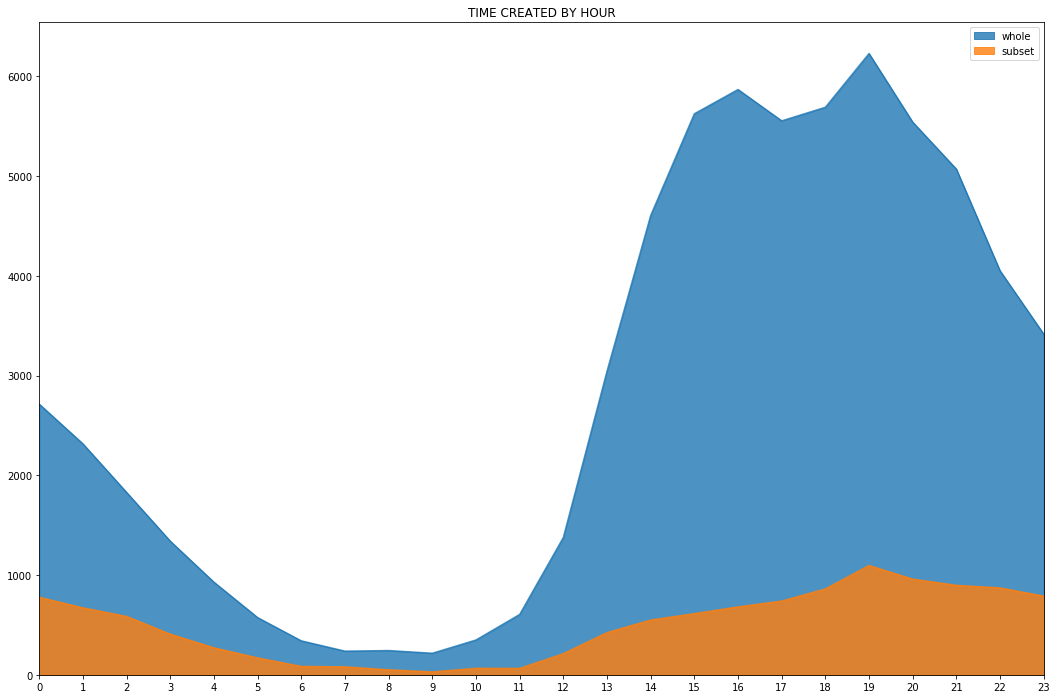

In [115]:
# create dataframes from hourly data for plotting
df_created_hours = pandas.DataFrame([len(created_hours[i]) for i in range(24)], columns=['whole'])
df_created_hours['subset'] = pandas.Series([len(created_hours_subset[i]) for i in range(24)])
df_created_hours.plot.area(stacked=False, title='TIME CREATED BY HOUR', xticks=[i for i in range(24)], alpha=0.8)

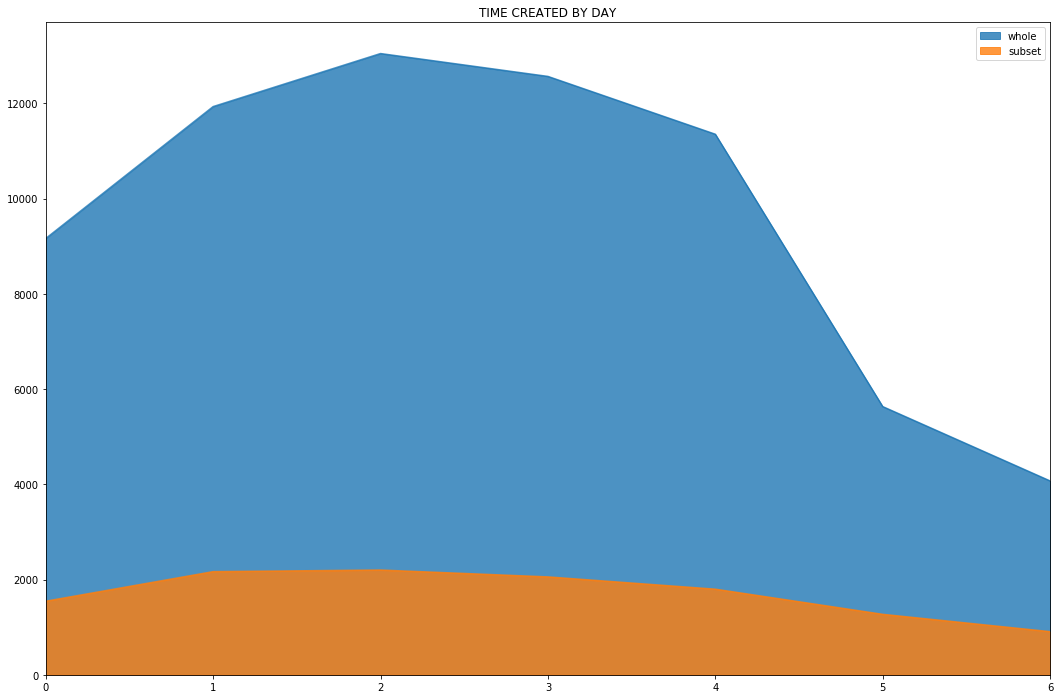

In [116]:
# create dataframes from daily data for plotting
df_created_days = pandas.DataFrame([len(created_days[i]) for i in range(7)], columns=['whole'])
df_created_days['subset'] = pandas.Series([len(created_days_subset[i]) for i in range(7)])
df_created_days.plot.area(stacked=False, title='TIME CREATED BY DAY', xticks=[i for i in range(7)], alpha=0.8)

In [117]:
# sort tweets by hour and they were created
deleted_hours = {i: [] for i in range(24)}
deleted_days = {i: [] for i in range(7)}

for i in range(len(deletweet)):
    deleted_hours[deletweet['modified'][i].hour].append(deletweet['id'][i])
    deleted_days[deletweet['modified'][i].weekday()].append(deletweet['id'][i])

In [118]:
# do the same for the 10+ hour subset
deleted_hours_subset = {i: [] for i in range(24)}
deleted_days_subset = {i: [] for i in range(7)}

for i in range(len(deletweet)):
    if deletweet['id'][i] in subset_ids:
        deleted_hours_subset[deletweet['modified'][i].hour].append(deletweet['id'][i])
        deleted_days_subset[deletweet['modified'][i].weekday()].append(deletweet['id'][i])

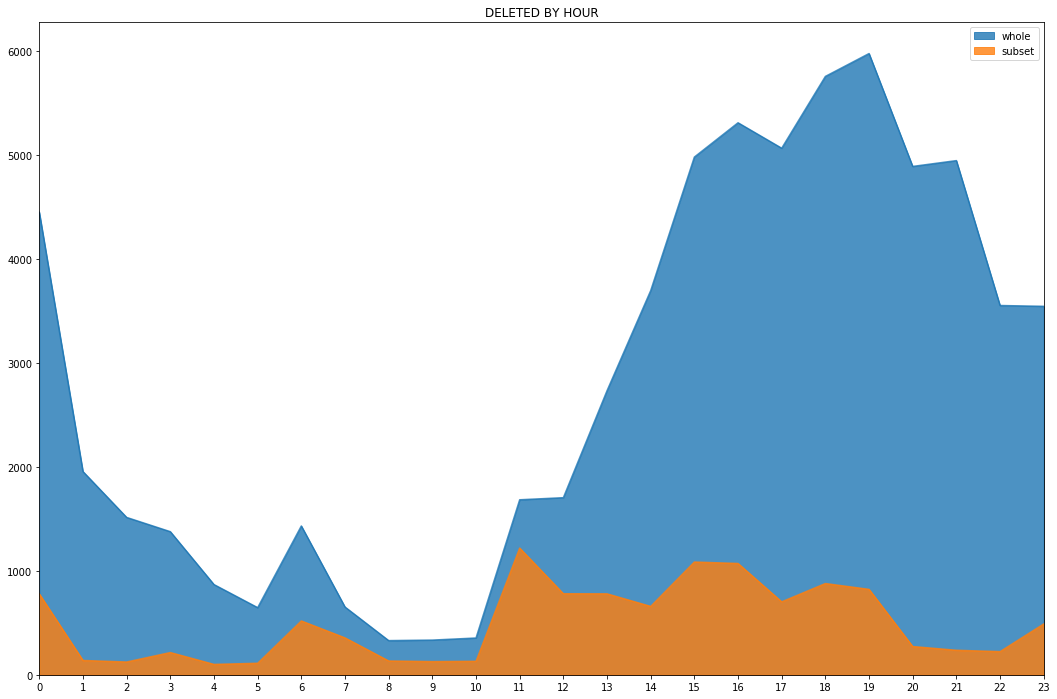

In [122]:
# create dataframes from hourly data for plotting
df_deleted_hours = pandas.DataFrame([len(deleted_hours[i]) for i in range(24)], columns=['whole'])
df_deleted_hours['subset'] = pandas.Series([len(deleted_hours_subset[i]) for i in range(24)])
df_deleted_hours.plot.area(stacked=False, title='DELETED BY HOUR', xticks=[i for i in range(24)], alpha=0.8)

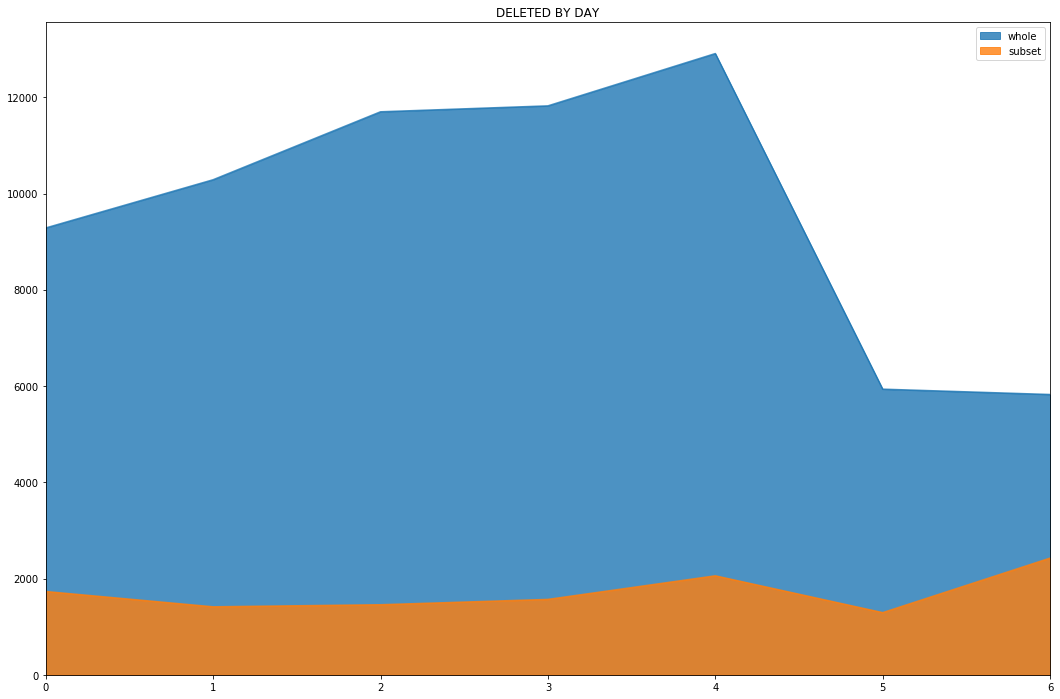

In [123]:
# create dataframes from daily data for plotting
df_deleted_days = pandas.DataFrame([len(deleted_days[i]) for i in range(7)], columns=['whole'])
df_deleted_days['subset'] = pandas.Series([len(deleted_days_subset[i]) for i in range(7)])
df_deleted_days.plot.area(stacked=False, title='DELETED BY DAY', xticks=[i for i in range(7)], alpha=0.8)